In [2]:
import praw

In [3]:
reddit = praw.Reddit(client_id='Redacted',
                    client_secret= 'Redacted',
                    user_agent='Redacted',
                    username='Redacted',
                    password='Redacted',)

In [4]:
#Poll Reddit by sub
sub='LiverpoolFC'
subReddit = reddit.subreddit(sub)


In [5]:
total_limit = 100
Player_Ratings = []
cycle= True
count = 0
beginning_of_season = 1659744000


In [6]:

hot_liv = subReddit.search('Player Ratings')

submission_list = [
    x for x in hot_liv
    if (x.created_utc >= beginning_of_season and x.link_flair_text == 'Player Ratings')
]



In [56]:
import pandas as pd
data = pd.DataFrame()

for i in submission_list:
    submission = reddit.submission(i)
    finaltitle = ''
    title = i.title.split()
    for i in range(len(title)):
        if ']' in title[i]:
            newtitle = title[i+1::]
            finaltitle = ' '.join(newtitle)
    print(finaltitle)
    data[finaltitle] = 0
    
    comment_data = []
    
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_data.append(str(comment.body))
        
    print(len(comment_data))
    
    ser = pd.Series(comment_data)
    data[finaltitle] = ser


LIVERPOOL FC 2 - 5 REAL MADRID
138
CRYSTAL PALACE 0 - 0 LIVERPOOL FC
89
LIVERPOOL FC 2 - 0 WOLVES
45
WOLVES 3 - 0 LIVERPOOL FC
67
NEWCASTLE 0 - 2 LIVERPOOL FC
14
LIVERPOOL FC 2 - 0 EVERTON
26
BRIGHTON 2 - 1 LIVERPOOL FC
91

84
BRIGHTON 3 - 0 LIVERPOOL FC
26
WOLVES 0 - 1 LIVERPOOL FC & LIVERPOOL FC 0 - 0 CHELSEA
11
Mid-Season Review & Southampton
15
Liverpool 1 - 0 Man City
34
Liverpool 3 - 1 Southampton
10
Liverpool 1 - 2 Leeds
15
Spurs 1 - 2 Liverpool
9
Liverpool 1 - 0 West Ham
23
EVERTON 0 - 0 LIVERPOOL FC & NAPOLI 4 - 1 LIVERPOOL FC
72
Liverpool 1 - 0 Man City
22
Nottingham Forest 1 - 0 Liverpool
15
Fulham 2 - 2 Liverpool
126
Arsenal 3 - 2 Liverpool
21
Rangers 1 - 7 Liverpool
13
Everton 0 - 0 Liverpool
51
Liverpool 3 - 3 Brighton
15
Nottingham Forest 1 - 0 Liverpool
8
Spurs
5
Liverpool 2 - 1 Ajax
23
Liverpool 0 (3) - (2) 0 Derby County
3
LIVERPOOL FC 1 - 1 CRYSTAL PALACE
49
Leeds
4
Arsenal
7
Liverpool 1 - 0 West Ham
6
Manchester United 2 - 1 Liverpool
41
Liverpool 9 - 0 Bournemouth


C:\Users\mjjyo\AppData\Local\Temp\ipykernel_4476\2909672879.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series(comment_data)


In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = (stopwords.words('english'))
new_stop = ['I', 'game','like', 'think', 'get', 'one', 'The', 'much', 'We', 'going', 'still', 'would', 'He', 'good', "he's", 'also', 'could']
stop.extend(new_stop)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mjjyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
corpus = []

for col in data.columns:
    for comment in data[col].dropna():
        new = comment.split()
        corpus = corpus + [word for word in new]


In [11]:
from collections import Counter
import seaborn as sns

In [12]:
counter = Counter(corpus)
most = counter.most_common()

<AxesSubplot:>

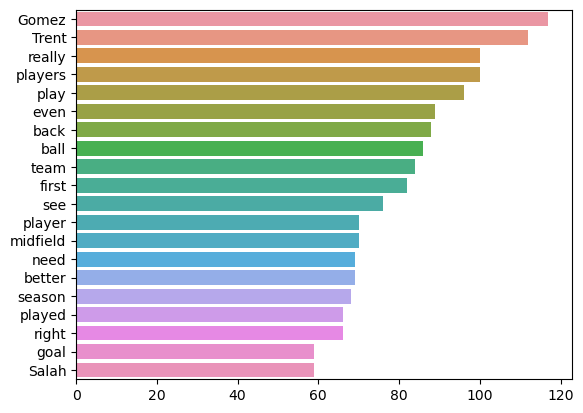

In [13]:
x, y = [], []

for word, count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x)

In [14]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

<AxesSubplot:>

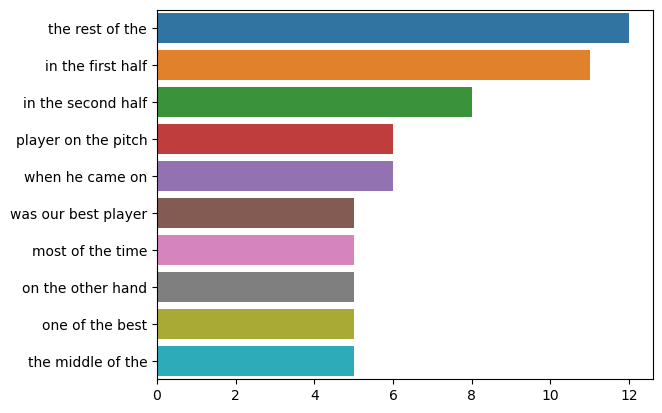

In [15]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                 for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    return words_freq[:10]

comment_list_data = []

for col in data.columns:
    for comment in data[col].dropna():
        temp = comment.split()
        length = len(temp)
        comment_list_data.append(comment)
        
# Create bigrams
top_n_bigrams = get_top_ngram(comment_list_data, 4)[:10]
x, y = map(list, zip(*top_n_bigrams))
sns.barplot(x=y, y=x)

In [16]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [149]:
moodDF = pd.DataFrame()

In [151]:
#for each column in the data
for col in data.columns:
    col_list = []
    #for each comment in each column
    for comment in data[col].dropna():
        #split text into words
        temp = comment.split(' ')
        #find length
        length = len(temp)
        #need to restrict length of paragraph so that the sentiment pipeline can work
        if length > 375:
            new_comment = ' '.join(temp[:375])
            sent = sentiment_pipeline(new_comment)
            col_list.append(sent[0])

        else:
            sent = sentiment_pipeline(comment)
            col_list.append(sent[0])
            
    moodDF.loc[:, col] = pd.Series(col_list)

In [152]:
moodDF

,LIVERPOOL FC 2 - 5 REAL MADRID,CRYSTAL PALACE 0 - 0 LIVERPOOL FC,LIVERPOOL FC 2 - 0 WOLVES,WOLVES 3 - 0 LIVERPOOL FC,NEWCASTLE 0 - 2 LIVERPOOL FC,LIVERPOOL FC 2 - 0 EVERTON,BRIGHTON 2 - 1 LIVERPOOL FC,,BRIGHTON 3 - 0 LIVERPOOL FC,WOLVES 0 - 1 LIVERPOOL FC & LIVERPOOL FC 0 - 0 CHELSEA,...,Arsenal,Manchester United 2 - 1 Liverpool,Liverpool 9 - 0 Bournemouth,Liverpool 2 - 0 Rangers,Man United 2 - 1 Liverpool,Napoli 4 - 1 Liverpool,Liverpool 2 - 0 Napoli,Liverpool 2-0 Rangers,Liverpool 1 - 1 Crystal Palace,Ajax 0 - 3 Liverpool
0,"{'label': 'POSITIVE', 'score': 0.9996640682220...","{'label': 'POSITIVE', 'score': 0.9847550392150...","{'label': 'NEGATIVE', 'score': 0.9983417987823...","{'label': 'POSITIVE', 'score': 0.9930383563041...","{'label': 'POSITIVE', 'score': 0.9988037347793...","{'label': 'POSITIVE', 'score': 0.999821126461029}","{'label': 'NEGATIVE', 'score': 0.9987480640411...","{'label': 'NEGATIVE', 'score': 0.9976763129234...","{'label': 'POSITIVE', 'score': 0.991081714630127}","{'label': 'NEGATIVE', 'score': 0.9951063394546...",...,"{'label': 'NEGATIVE', 'score': 0.9438222050666...","{'label': 'NEGATIVE', 'score': 0.5993361473083...","{'label': 'POSITIVE', 'score': 0.9985941052436...","{'label': 'POSITIVE', 'score': 0.9990147352218...","{'label': 'NEGATIVE', 'score': 0.9996579885482...","{'label': 'POSITIVE', 'score': 0.9980594515800...","{'label': 'NEGATIVE', 'score': 0.9977962970733...","{'label': 'NEGATIVE', 'score': 0.9397669434547...","{'label': 'NEGATIVE', 'score': 0.998684823513031}","{'label': 'POSITIVE', 'score': 0.9346069097518..."
1,"{'label': 'NEGATIVE', 'score': 0.7482395172119...","{'label': 'POSITIVE', 'score': 0.9937064051628...","{'label': 'NEGATIVE', 'score': 0.9453182816505...","{'label': 'NEGATIVE', 'score': 0.9996836185455...","{'label': 'POSITIVE', 'score': 0.9951555728912...","{'label': 'NEGATIVE', 'score': 0.9982579350471...","{'label': 'NEGATIVE', 'score': 0.9693413376808...","{'label': 'NEGATIVE', 'score': 0.9603590965270...","{'label': 'NEGATIVE', 'score': 0.9778009057044...","{'label': 'NEGATIVE', 'score': 0.691984236240387}",...,"{'label': 'POSITIVE', 'score': 0.9937220215797...","{'label': 'NEGATIVE', 'score': 0.9997972846031...","{'label': 'POSITIVE', 'score': 0.9970468878746...","{'label': 'NEGATIVE', 'score': 0.9993736147880...","{'label': 'NEGATIVE', 'score': 0.9834287762641...","{'label': 'NEGATIVE', 'score': 0.9986592531204...","{'label': 'NEGATIVE', 'score': 0.9979636669158...","{'label': 'POSITIVE', 'score': 0.9998199343681...","{'label': 'POSITIVE', 'score': 0.9983620047569...",NaN
2,"{'label': 'NEGATIVE', 'score': 0.9996683597564...","{'label': 'NEGATIVE', 'score': 0.9992011189460...","{'label': 'POSITIVE', 'score': 0.9974405765533...","{'label': 'NEGATIVE', 'score': 0.9837170839309...","{'label': 'NEGATIVE', 'score': 0.9941689968109...","{'label': 'POSITIVE', 'score': 0.9868572354316...","{'label': 'POSITIVE', 'score': 0.9991241097450...","{'label': 'POSITIVE', 'score': 0.9734964370727...","{'label': 'NEGATIVE', 'score': 0.9071852564811...","{'label': 'POSITIVE', 'score': 0.9987295269966...",...,"{'label': 'POSITIVE', 'score': 0.9988459348678...","{'label': 'NEGATIVE', 'score': 0.9354757070541...","{'label': 'NEGATIVE', 'score': 0.9795693755149...","{'label': 'NEGATIVE', 'score': 0.9991574287414...","{'label': 'NEGATIVE', 'score': 0.9898446798324...","{'label': 'NEGATIVE', 'score': 0.9955399632453...",NaN,"{'label': 'NEGATIVE', 'score': 0.9951621890068...","{'label': 'POSITIVE', 'score': 0.9832404255867...",NaN
3,"{'label': 'NEGATIVE', 'score': 0.9963483214378...","{'label': 'NEGATIVE', 'score': 0.9949740171432...","{'label': 'POSITIVE', 'score': 0.9973822236061...","{'label': 'POSITIVE', 'score': 0.9477429986000...","{'label': 'POSITIVE', 'score': 0.9943885207176...","{'label': 'POSITIVE', 'score': 0.9924718141555...","{'label': 'POSITIVE', 'score': 0.9996856451034...","{'label': 'POSITIVE', 'score': 0.9907405376434...","{'label': 'POSITIVE', 'score': 0.9984049201011...","{'la

In [159]:
new_moodDF=moodDF.copy()
for column in new_moodDF.columns: 
    if new_moodDF[column].count() <= 7: 
        new_moodDF=new_moodDF.drop(column, axis=1) 

In [160]:
new_moodDF
        
    

,LIVERPOOL FC 2 - 5 REAL MADRID,CRYSTAL PALACE 0 - 0 LIVERPOOL FC,LIVERPOOL FC 2 - 0 WOLVES,WOLVES 3 - 0 LIVERPOOL FC,NEWCASTLE 0 - 2 LIVERPOOL FC,LIVERPOOL FC 2 - 0 EVERTON,BRIGHTON 2 - 1 LIVERPOOL FC,,BRIGHTON 3 - 0 LIVERPOOL FC,WOLVES 0 - 1 LIVERPOOL FC & LIVERPOOL FC 0 - 0 CHELSEA,...,Arsenal 3 - 2 Liverpool,Rangers 1 - 7 Liverpool,Everton 0 - 0 Liverpool,Liverpool 3 - 3 Brighton,LIVERPOOL FC 1 - 1 CRYSTAL PALACE,Manchester United 2 - 1 Liverpool,Liverpool 9 - 0 Bournemouth,Man United 2 - 1 Liverpool,Napoli 4 - 1 Liverpool,Liverpool 1 - 1 Crystal Palace
0,"{'label': 'POSITIVE', 'score': 0.9996640682220...","{'label': 'POSITIVE', 'score': 0.9847550392150...","{'label': 'NEGATIVE', 'score': 0.9983417987823...","{'label': 'POSITIVE', 'score': 0.9930383563041...","{'label': 'POSITIVE', 'score': 0.9988037347793...","{'label': 'POSITIVE', 'score': 0.999821126461029}","{'label': 'NEGATIVE', 'score': 0.9987480640411...","{'label': 'NEGATIVE', 'score': 0.9976763129234...","{'label': 'POSITIVE', 'score': 0.991081714630127}","{'label': 'NEGATIVE', 'score': 0.9951063394546...",...,"{'label': 'POSITIVE', 'score': 0.9994217157363...","{'label': 'POSITIVE', 'score': 0.9967371821403...","{'label': 'POSITIVE', 'score': 0.9935787916183...","{'label': 'NEGATIVE', 'score': 0.9967206120491...","{'label': 'POSITIVE', 'score': 0.9306978583335...","{'label': 'NEGATIVE', 'score': 0.5993361473083...","{'label': 'POSITIVE', 'score': 0.9985941052436...","{'label': 'NEGATIVE', 'score': 0.9996579885482...","{'label': 'POSITIVE', 'score': 0.9980594515800...","{'label': 'NEGATIVE', 'score': 0.998684823513031}"
1,"{'label': 'NEGATIVE', 'score': 0.7482395172119...","{'label': 'POSITIVE', 'score': 0.9937064051628...","{'label': 'NEGATIVE', 'score': 0.9453182816505...","{'label': 'NEGATIVE', 'score': 0.9996836185455...","{'label': 'POSITIVE', 'score': 0.9951555728912...","{'label': 'NEGATIVE', 'score': 0.9982579350471...","{'label': 'NEGATIVE', 'score': 0.9693413376808...","{'label': 'NEGATIVE', 'score': 0.9603590965270...","{'label': 'NEGATIVE', 'score': 0.9778009057044...","{'label': 'NEGATIVE', 'score': 0.691984236240387}",...,"{'label': 'NEGATIVE', 'score': 0.8482744693756...","{'label': 'POSITIVE', 'score': 0.9986158609390...","{'label': 'NEGATIVE', 'score': 0.8916438817977...","{'label': 'NEGATIVE', 'score': 0.9771437644958...","{'label': 'POSITIVE', 'score': 0.994403064250946}","{'label': 'NEGATIVE', 'score': 0.9997972846031...","{'label': 'POSITIVE', 'score': 0.9970468878746...","{'label': 'NEGATIVE', 'score': 0.9834287762641...","{'label': 'NEGATIVE', 'score': 0.9986592531204...","{'label': 'POSITIVE', 'score': 0.9983620047569..."
2,"{'label': 'NEGATIVE', 'score': 0.9996683597564...","{'label': 'NEGATIVE', 'score': 0.9992011189460...","{'label': 'POSITIVE', 'score': 0.9974405765533...","{'label': 'NEGATIVE', 'score': 0.9837170839309...","{'label': 'NEGATIVE', 'score': 0.9941689968109...","{'label': 'POSITIVE', 'score': 0.9868572354316...","{'label': 'POSITIVE', 'score': 0.9991241097450...","{'label': 'POSITIVE', 'score': 0.9734964370727...","{'label': 'NEGATIVE', 'score': 0.9071852564811...","{'label': 'POSITIVE', 'score': 0.9987295269966...",...,"{'label': 'POSITIVE', 'score': 0.7299280166625...","{'label': 'POSITIVE', 'score': 0.9997660517692...","{'label': 'NEGATIVE', 'score': 0.9910491704940...","{'label': 'NEGATIVE', 'score': 0.9993140697479...","{'label': 'POSITIVE', 'score': 0.9991090893745...","{'label': 'NEGATIVE', 'score': 0.9354757070541...","{'label': 'NEGATIVE', 'score': 0.9795693755149...","{'label': 'NEGATIVE', 'score': 0.9898446798324...","{'label': 'NEGATIVE', 'score': 0.9955399632453...","{'label': 'POSITIVE', 'score': 0.9832404255867..."
3,"{'label': 'NEGATIVE', 'score': 0.9963483214378...","{'label': 'NEGATIVE', 'score': 0.9949740171432...","{'label': 'POSITIVE', 'score': 0.9973822236061...","{'label': 'POSITIVE', 'score': 0.9477429986000...","{'label': 'POSITIVE', 'score': 0.9943885207176...","{'label': 'POSITIVE', 'score': 0.99

In [178]:
percentage = pd.DataFrame()


In [183]:
for col in new_moodDF.columns:
    num = 0
    num_negative = 0
    for item in new_moodDF[col].dropna():
        if item['label'] == 'NEGATIVE':
            num_negative += 1
        num += 1
    percentage[col] = [(num_negative/num)]


In [184]:
percentage

,LIVERPOOL FC 2 - 5 REAL MADRID,CRYSTAL PALACE 0 - 0 LIVERPOOL FC,LIVERPOOL FC 2 - 0 WOLVES,WOLVES 3 - 0 LIVERPOOL FC,NEWCASTLE 0 - 2 LIVERPOOL FC,LIVERPOOL FC 2 - 0 EVERTON,BRIGHTON 2 - 1 LIVERPOOL FC,,BRIGHTON 3 - 0 LIVERPOOL FC,WOLVES 0 - 1 LIVERPOOL FC & LIVERPOOL FC 0 - 0 CHELSEA,...,Arsenal 3 - 2 Liverpool,Rangers 1 - 7 Liverpool,Everton 0 - 0 Liverpool,Liverpool 3 - 3 Brighton,LIVERPOOL FC 1 - 1 CRYSTAL PALACE,Manchester United 2 - 1 Liverpool,Liverpool 9 - 0 Bournemouth,Man United 2 - 1 Liverpool,Napoli 4 - 1 Liverpool,Liverpool 1 - 1 Crystal Palace
0,0.73913,0.685393,0.6,0.626866,0.357143,0.423077,0.714286,0.702381,0.653846,0.727273,...,0.47619,0.384615,0.627451,0.727273,0.612245,0.658537,0.363636,0.6875,0.461538,0.538462
